In [ ]:
import pandas as pd
df = pd.read_parquet("hf://datasets/ade-benchmark-corpus/ade_corpus_v2/Ade_corpus_v2_classification/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)

                                                    text  label
4      METHODS: We report two cases of pseudoporphyri...      1
7      RESULTS: A 44-year-old man taking naproxen for...      1
8      RESULTS: A 44-year-old man taking naproxen for...      1
9      RESULTS: A 44-year-old man taking naproxen for...      1
14     We describe the side effects of 5-FU in a colo...      1
...                                                  ...    ...
22962                               METHOD: Case report.      0
22981                                     A case report.      0
23206                               Report of two cases.      0
23224                 Case report and literature review.      0
23445                       His recovery was uneventful.      0

[2620 rows x 2 columns]


In [ ]:
df_no_duplicates = df.drop_duplicates()
df=df_no_duplicates

In [ ]:
import pandas as pd


df_random_sample = df.groupby('label').apply(lambda x: x.sample(200)).reset_index(drop=True)

# Show the result
print(df_random_sample)


                                                  text  label
0    During the 12th week of treatment she showed t...      0
1    A patient with chest pain was found to have ob...      0
2    Histochemistry identified a calcium containing...      0
3    Between 1989 and 1996, 4 cases of Pneumocystis...      0
4    Granulocyte macrophage-colony-stimulating fact...      0
..                                                 ...    ...
395  Temporary neurologic abnormalities were observ...      1
396  Reversal of severe methanol-induced visual imp...      1
397  This case and other published evidence should ...      1
398  Presented is a case of acute renal failure ind...      1
399  Kaposi's sarcoma in a patient treated with ima...      1

[400 rows x 2 columns]


<ipython-input-3-cec3f959cfd0>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random_sample = df.groupby('label').apply(lambda x: x.sample(200)).reset_index(drop=True)


In [ ]:
nan_values = df.isna().count()
print(nan_values)

text     20896
label    20896
dtype: int64


In [ ]:
df['char_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['token_count'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20896 entries, 0 to 23515
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         20896 non-null  object
 1   label        20896 non-null  int64 
 2   char_length  20896 non-null  int64 
 3   word_count   20896 non-null  int64 
 4   token_count  20896 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 979.5+ KB


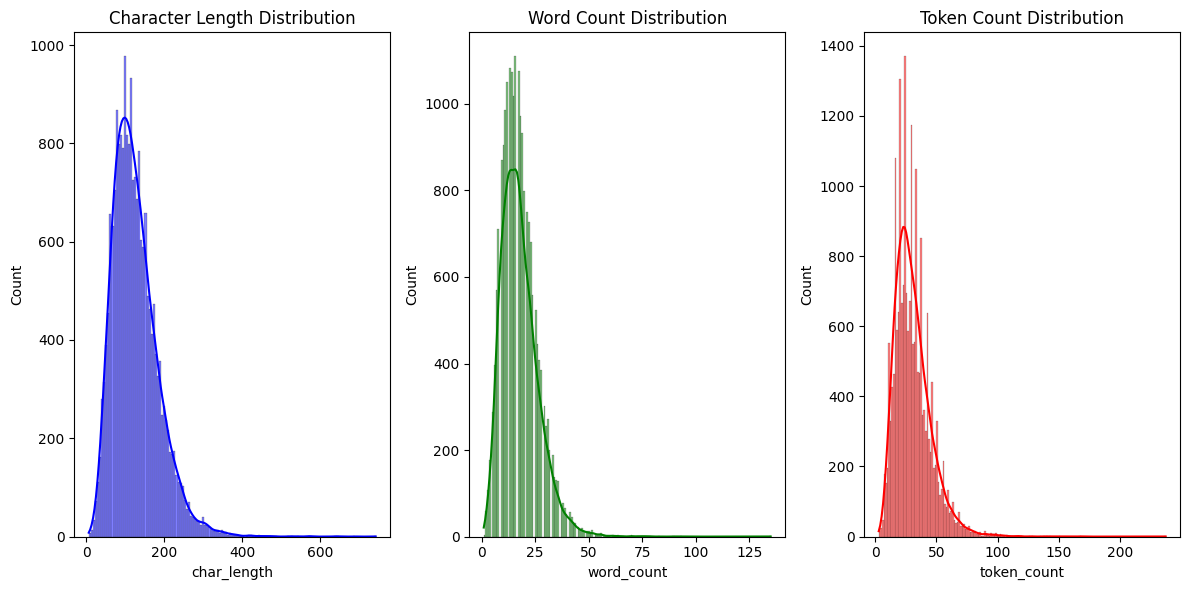

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
plt.figure(figsize=(12, 6))

# Plotting the character length distribution
plt.subplot(1, 3, 1)
sns.histplot(df['char_length'], kde=True, color='blue')
plt.title('Character Length Distribution')

# Plotting the word count distribution
plt.subplot(1, 3, 2)
sns.histplot(df['word_count'], kde=True, color='green')
plt.title('Word Count Distribution')

# Plotting the token count distribution
plt.subplot(1, 3, 3)
sns.histplot(df['token_count'], kde=True, color='red')
plt.title('Token Count Distribution')

plt.tight_layout()
plt.show()


<ipython-input-15-688468c5e953>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


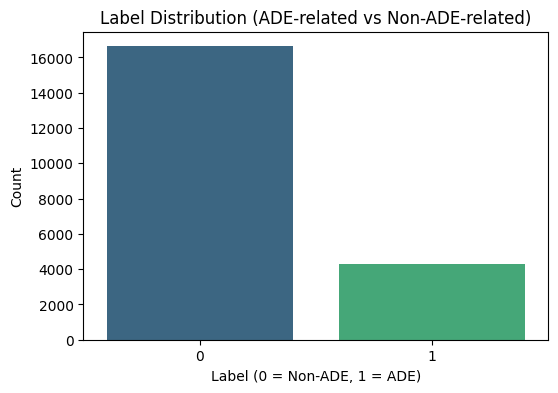

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Label Distribution (ADE-related vs Non-ADE-related)')
plt.xlabel('Label (0 = Non-ADE, 1 = ADE)')
plt.ylabel('Count')
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


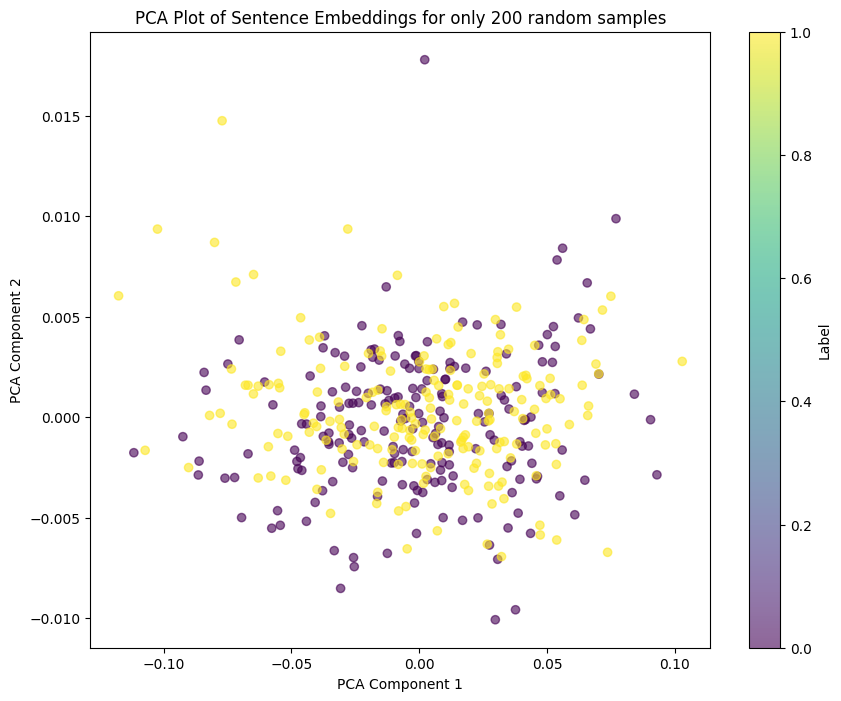

In [ ]:
import gensim
import numpy as np
import pandas as pd
import nltk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')


# Tokenize the sentences into words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in df_random_sample['text']]

# Train Word2Vec model on your dataset
word2vec_model = gensim.models.Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

def sentence_to_vec(sentence, model):
    tokens = word_tokenize(sentence.lower())
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) == 0:  # In case no words are in the vocabulary
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

sentence_vectors = np.array([sentence_to_vec(sentence, word2vec_model) for sentence in df_random_sample['text']])

# Reduce dimensionality to 2D using PCA or t-SNE for visualization
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(sentence_vectors)

# For better separation, we can also use t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_tsne = tsne.fit_transform(sentence_vectors)

# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=df_random_sample['label'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Label')
plt.title('PCA Plot of Sentence Embeddings for only 200 random samples')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()




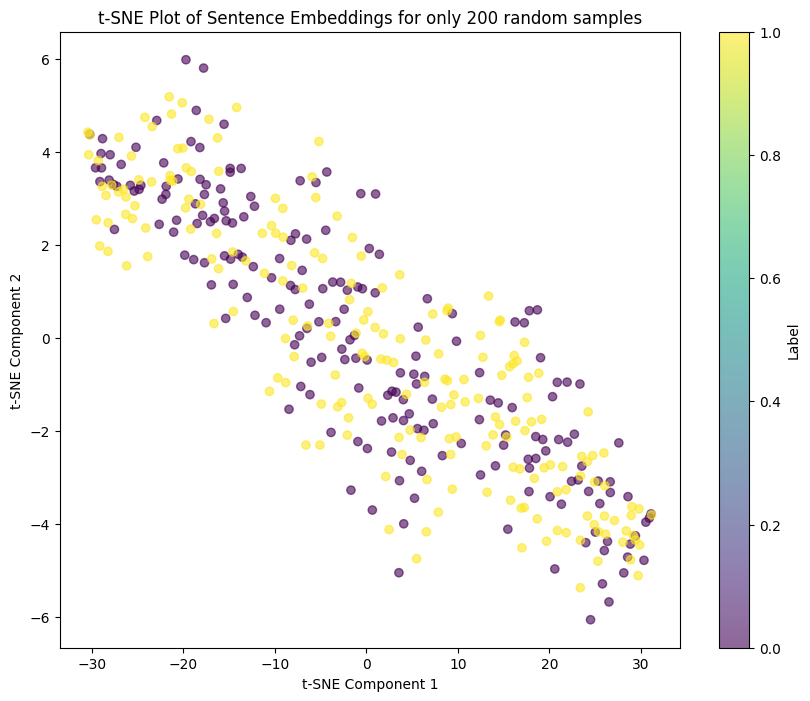

In [ ]:
# Plot t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=df_random_sample['label'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Label')
plt.title('t-SNE Plot of Sentence Embeddings for only 200 random samples')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()